In [1]:
from __future__ import absolute_import, division, print_function
from matplotlib.font_manager import _rebuild; _rebuild()
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

#Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as spio
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp

tf.logging.set_verbosity(tf.logging.INFO)

Using TensorFlow backend.


In [3]:
"""Set all global parameters to be monitored"""

n_splits_o = 5
n_splits_i = 4
animal_ID = 12
factor_red = 50

# To reduce the computational expense and the number of features to try in PCA during Hyperparameter optimization
nb_feats_min = 70
nb_feats_max = 110

In [13]:
"""Load the dataset and set randomness."""
# (from Emma's code)

# Initialize random number generator for reproducibility.
seed = 7
np.random.seed(seed)

# Load in dataset.
data = spio.loadmat("features_10s_2019-01-30.mat");
features = data['features'];
labels = data['labels_features'];


# Get only features corresponding to animal selected.
animal_features = np.array(features)
labels = labels.transpose()
animal_labels = np.array(labels);

In [14]:
"""Reduce the number of classes: delete the seizures - Prediction model"""

a = np.where(animal_labels == 2)

animal_labels_tmp = np.delete(animal_labels, a)
animal_features_tmp = np.delete(animal_features, a, 0);
animal_labels = animal_labels_tmp
animal_features = animal_features_tmp

print(animal_labels.shape)
print(animal_features.shape)

(583541,)
(583541, 141)


In [15]:
"""Reducing the size of the vectors for easier computation"""
factor = factor_red

"""Shuffling the data to train/test on smaller subsets"""
shuffled_animal_features = np.empty(animal_features.shape, dtype=animal_features.dtype)
shuffled_animal_labels = np.empty(animal_labels.shape, dtype=animal_labels.dtype)
permutation = np.random.permutation(len(animal_labels))
for old_index, new_index in enumerate(permutation):
        shuffled_animal_features [new_index] = animal_features[old_index]
        shuffled_animal_labels[new_index] = animal_labels[old_index]
animal_features = shuffled_animal_features
animal_labels = shuffled_animal_labels

animal_features = animal_features[0:int(len(animal_features)/factor),:]
animal_labels = animal_labels[0:np.int(len(animal_labels)/factor)]

In [16]:
print(animal_labels.shape)
print(animal_features.shape)

(11670,)
(11670, 141)


# Cross validation whole loop

Process ended, outer fold  0 , inner fold  0
Process ended, outer fold  0 , inner fold  1
Process ended, outer fold  0 , inner fold  2
Process ended, outer fold  0 , inner fold  3
Process ended, outer fold  0
Process ended, outer fold  1 , inner fold  0
Process ended, outer fold  1 , inner fold  1
Process ended, outer fold  1 , inner fold  2
Process ended, outer fold  1 , inner fold  3
Process ended, outer fold  1
Process ended, outer fold  2 , inner fold  0
Process ended, outer fold  2 , inner fold  1
Process ended, outer fold  2 , inner fold  2
Process ended, outer fold  2 , inner fold  3
Process ended, outer fold  2
Process ended, outer fold  3 , inner fold  0
Process ended, outer fold  3 , inner fold  1
Process ended, outer fold  3 , inner fold  2
Process ended, outer fold  3 , inner fold  3
Process ended, outer fold  3
Process ended, outer fold  4 , inner fold  0
Process ended, outer fold  4 , inner fold  1
Process ended, outer fold  4 , inner fold  2
Process ended, outer fold  4 

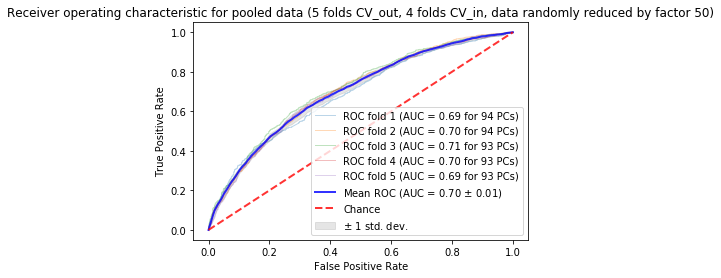

In [18]:
"""Split data into training and testing sets"""

# parameters:
n_splits_o = n_splits_o
n_splits_i = n_splits_i
nb_features_tot = animal_features.shape[1]

cv_o = StratifiedKFold(n_splits=n_splits_o)
cv_i = StratifiedKFold(n_splits=n_splits_i)


AUC_i = np.zeros((n_splits_o, n_splits_i, nb_features_tot))
AUC_means = np.zeros((n_splits_o, nb_features_tot))
# Acc_train_i = np.zeros((n_splits_o, n_splits_i))
# Acc_val_i = np.zeros((n_splits_o, n_splits_i))
Best_features = np.zeros(n_splits_o)
Best_features_valAUC = np.zeros(n_splits_o)
AUC_o = np.zeros(n_splits_o)

tprs = []
mean_fpr = np.linspace(0, 1, 100)


"""Outer loop"""
k_out = 0
for train_o, test in cv_o.split(animal_features, animal_labels):
    data_train_o = animal_features[train_o]
    data_test = animal_features[test]
    labels_train_o = animal_labels[train_o]
    labels_test = animal_labels[test]
    
    """Inner Loop"""
    k_in = 0
    for train_i, val in cv_i.split(data_train_o, labels_train_o):

        data_train_i = animal_features[train_i]
        data_val = animal_features[val]
        labels_train_i = animal_labels[train_i]
        labels_val = animal_labels[val]

        """Hyperparameter evaluation: Number of features to keep after PCA"""
        for k_feat in range(nb_feats_min, nb_feats_max+1):
            features_kept = k_feat + 1 

            clf = make_pipeline(StandardScaler(), PCA(n_components=features_kept), svm.SVC(kernel='rbf', gamma='scale', probability=True))
            y_score = clf.fit(data_train_i, labels_train_i)

            y_predict = clf.predict_proba(data_val)
            y_predict_train = clf.predict(data_train_i)

#             Acc_val_i[k_out, k_in] = metrics.accuracy_score(labels_val, y_predict)
#             Acc_train_i[k_out, k_in] = metrics.accuracy_score(labels_train_i, y_predict_train)
            fpr, tpr, thresholds = roc_curve(labels_val, y_predict[:, 1])
            AUC_i[k_out, k_in, k_feat] = auc(fpr, tpr)
        
        print('Process ended, outer fold ', k_out, ', inner fold ', k_in)
        k_in += 1
        
    AUC_means = np.mean(AUC_i, axis=1)
    
    """Choice of the best performing Hyperparameters:"""
    Best_features[k_out] = int(np.argmax(AUC_means[k_out,:]) + 1)
    Best_features_valAUC[k_out] = np.max(AUC_means[k_out,:])
    
    """Performance on the test set"""
    clf = make_pipeline(StandardScaler(), PCA(n_components=int(Best_features[k_out])), svm.SVC(kernel='rbf', gamma='scale', probability=True))
    y_score = clf.fit(data_train_o, labels_train_o)
    
    y_predict = clf.predict_proba(data_test)
    y_predict_train = clf.predict(data_train_o)
    
    """ROC curve"""
    fpr, tpr, thresholds = roc_curve(labels_test, y_predict[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    AUC_o[k_out] = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f for %d PCs)' % (k_out+1, AUC_o[k_out], int(Best_features[k_out])))  
    
    print('Process ended, outer fold ', k_out)
    k_out += 1

"""mean ROC curve"""             
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(AUC_o)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')       
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for pooled data (%d folds CV_out, %d folds CV_in, data randomly reduced by factor %d)' % (n_splits_o, n_splits_i, factor_red))
plt.legend(loc="lower right")
plt.savefig('ROC_pooled.png')  
plt.show()          